### **Preparation**

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
from google.colab import files
from collections import deque
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
import zipfile
import io
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Text Data**
- the data directory ('movie_review') consists of two sub-directories ('pos') and ('neg') for positive and negative, respectively
- each sub-directory includes a list of files for review texts
- the preprocessing given by the below codes transforms each text into the frequency information

In [2]:
uploaded = files.upload()

Saving pos.zip to pos.zip


In [0]:
pos = deque()   #positive review를 모아둔 deque, size = 1000
with zipfile.ZipFile('pos.zip') as z:
    for filename in z.namelist():
        if not os.path.isdir(filename):
            # read the file
            with z.open(filename) as f:
                for data in f:
                  lines = f.readlines()
                  pos.append(lines)

In [4]:
uploaded = files.upload()

Saving neg.zip to neg.zip


In [0]:
neg = deque()   #negative review를 모아둔 deque, size = 1000
with zipfile.ZipFile('neg.zip') as z:
    for filename in z.namelist():
        if not os.path.isdir(filename):
            # read the file
            with z.open(filename) as f:
                for data in f:
                  lines = f.readlines()
                  neg.append(lines)

### **Data Preprocessing**
- Remove unnecessary characters
- Lemmatization
- TFidVectorizer

In [153]:
documents = []
Y = np.empty(2000, dtype=int)

stemmer = WordNetLemmatizer()

for sen in range(0, 1000):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(pos[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

for sen in range(0, 1000):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(neg[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

X_train = []
X_test = []

Y_train  = np.empty(1400, dtype=int)    # 1 - 700개, 0 - 700개 순으로 이루어진 numpy 배열
Y_test  = np.empty(600, dtype=int)      # 1 - 300개, 0 - 300개 순으로 이루어진 numpy 배열

for i in range(0, 2000):
  if i < 1000:
    Y[i] = 1
  else:
    Y[i] = 0

tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features=1500)
X = tfidf_vectorizer.fit_transform(documents).toarray()
print("vectorizer:",X[0])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1000)

"""
#vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
vectorizer = CountVectorizer(max_features=1500, min_df=0, lowercase=False)
X_train = vectorizer.fit_transform(X_train).toarray()

tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()
X_train = X_train.T

X_test = vectorizer.fit_transform(X_test).toarray()
X_test = tfidfconverter.fit_transform(X_test).toarray()
"""
X_train = X_train.T
X_test = X_test.T

#print(len(X_train))         # 1500
#print(X_train[0])
#print(len(X_train[0]))      # 1400
#print(X_train.shape)        # size : 1500 x 1400, data 1400개이며, 각 data마다 1500개의 특징이 추출됨! 
#print(X_test.shape)         # size : 1500 x 600, data 600개이며, 각 data 마다 1500개의 특징이 추출됨!

vectorizer: [0. 0. 0. ... 0. 0. 0.]


### **Neural Network Architecture**
- build a classifier using neural networks for the text cateogrization with binary labels that are either positive or negative
- construct a neural network that consists of an input layer, an output layer and a sequence of hidden layers
- each hidden layer is defined by a logistic unit
- a logistic unit consists of a fully connected layer with a bias followed by the sigmoid activation function 
- the dimensions of the layers are defined by:
    - input unit : 1500 (+ a bias)
    - hidden unit : 10 (+ a bias)
    - output unit : 1

In [0]:
def forward(theta, value):
  result = np.matmul(theta, value)
  
  return result

In [0]:
def sigmoid(value):
  value = np.multiply(value,-1)
  value = np.exp(value)
  value = np.add(1,value)
  value = np.divide(1, value)
  
  return value

In [0]:
def addBias(value, bias):
  value = np.add(value, bias)
  
  return value

In [0]:
def neuralNet(x, u, v, bias0, bias1):    #data, theta0, theta1, theta2, bias0, bias1, bias2
  y_hat = forward(u, x)
  y_hat = addBias(y_hat, bias0)
  y = sigmoid(y_hat)
  z_hat = forward(v, y)
  z_hat = addBias(z_hat, bias1)
  z = sigmoid(z_hat)

  return y, z

### **Objective Function**
- $J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^{9}( - l^{(i)}_k \log( h^{(i)}_k ) - (1 - l^{(i)}_k) \log(1 - h^{(i)}_k) ) + \frac{\lambda}{2 n} \sum_{j=1}^n \theta_j^2$ 
- $\theta_j$ denotes a model parameter where $j = 1, 2, \cdots, n$
- $\lambda$ is a control parameter for the regularization based on the $L_2^2$-norm (weight decay)
- $n$ is the total number of all the model parameters over the entire neural network
- $h^{(i)}_k$ denotes the $k$-th element of the output layer for $i$-th sample data

In [0]:
def objectiveFunction(data, l, lamda, y, z, theta0, theta1, b0, b1):    
  length = len(data[0])                    #두는 이유는 trainig 1400, test 600개  갯수가 달라서
  
  cost1 = np.log(z)      
  cost1 = np.multiply(cost1, l)
  cost1 = np.multiply(cost1, -1)
  cost2 = np.subtract(1, z)
  cost2 = np.log(cost2)
  temp = np.subtract(1, l)
  cost2 = np.multiply(cost2, temp)
  cost = np.subtract(cost1, cost2)
  cost = np.sum(cost)
  cost = np.divide(cost,length)
  cost_r1 = np.multiply(theta0, theta0)
  cost_r1 = np.sum(cost_r1)
  cost_r2 = np.multiply(theta1, theta1)
  cost_r2 = np.sum(cost_r2)
  cost_b1 = np.multiply(b0, b0)
  cost_b1 = np.sum(cost_b1)
  cost_b2 = np.multiply(b1, b1)
  cost_b2 = np.sum(cost_b2)
  cost_r = np.add(cost_r1, cost_r2)
  cost_b = np.add(cost_b1, cost_b2)
  cost_r = np.add(cost_r, cost_b)
  cost_r = cost_r * lamda / (2*15021)        
  cost += cost_r
  
  return cost

### **Gradient Descent (Back-propagation)**
- $\theta_{k}^{(t+1)} = \theta_{k}^{(t)} - \alpha \frac{\partial J(\theta^{(t)})}{\partial \theta_{k}}$, for all $k$
- you should choose a learning rate $\alpha$ in such a way that the convergence is achieved
- you can use random initial conditions $\theta_k^{(0)}$ for all $k$ following a normal distribution with mean 0 and stardard deviation some number

In [0]:
def gradientDescent(data, l, lamda, learning_rate, y, z, theta0, theta1, b0, b1):
  lr = learning_rate
  length = len(data[0])
  x_transpose = data.T
  y_transpose = y.T

  #######theta1
  partial_1 = np.subtract(z, l)
  partial_theta1 = np.matmul(partial_1, y_transpose)
  regular_theta1 = np.sum(theta1)
  regular_theta1 = np.multiply(regular_theta1, lamda)
  regular_theta1 = np.divide(regular_theta1, 10) 
  partial_theta1 = np.add(partial_theta1, regular_theta1)
  partial_theta1 = np.multiply(partial_theta1, lr)
  theta1 = np.subtract(theta1, partial_theta1)
  
  #######bias1
  partial_bias1 = np.ones((1400,1), dtype=float)
  partial_bias1 = np.matmul(partial_1, partial_bias1)
  partial_bias1 = np.divide(partial_bias1, 1400)      
  partial_bias1 = np.multiply(partial_bias1, lr)
  b1 = np.subtract(b1, partial_bias1)

  #######theta0
  theta1_transpose = theta1.T
  partial_0 = np.matmul(theta1_transpose, partial_1)     
  partial_theta0 = np.matmul(partial_0, x_transpose)
  regular_theta0 = np.sum(theta0)
  regular_theta0 = np.multiply(regular_theta0, lamda)
  regular_theta0 = np.divide(regular_theta0, 15000) 
  partial_theta0 = np.add(partial_theta0, regular_theta0)
  partial_theta0 = np.multiply(partial_theta0, lr)
  theta0 = np.subtract(theta0, partial_theta0)

  #######bias0
  partial_bias0 = np.ones((1400,1), dtype=float)
  partial_bias0 = np.matmul(partial_0, partial_bias0)
  partial_bias0 = np.divide(partial_bias0, 1400)      
  partial_bias0 = np.multiply(partial_bias0, lr)
  b0 = np.subtract(b0, partial_bias0)

  return theta0, b0, theta1, b1

In [0]:
def checkAccuracy(data, label, z, theta0, b0):
  length = len(label)
  count = 0
  z = z.T
  
  for i in range(0, length):
    if z[i] >= 0.5:
      result = 1
    if z[i] < 0.5:
      result = 0
    if label[i] == result:
      count += 1
  accuracy = count / length * 100
  
  return accuracy

In [0]:
def predClassifier(z):
  z = z.T
  length = len(z)
  result  = np.empty(length, dtype=int)

  for i in range(0, length):
    if z[i] >= 0.5:
      result[i] = 1
    else:
      result[i] = 0

  return result

In [0]:
train_costs = deque()
test_costs = deque()
iters = deque()
train_accuracys = deque()
test_accuracys = deque()
predict_train = deque()
predict_test = deque()

In [0]:
def main():
  mu = 0
  sigma = 0.1
  lamda = 0.1

  theta_0 = np.random.normal(mu, sigma, size=(10,1500))   #size = 196x784
  theta_1 = np.random.normal(mu, sigma, size=(1,10))    #size = 49x196
  
  b_0 = np.random.normal(mu, sigma, size=(10,1))  
  b_1 = np.random.normal(mu, sigma, size=(1,1))                  

  lr = 0.00005                                                #learning rate

  #training step
  for iter in range(0, 9000):
    iters.append(iter)
    y, z = neuralNet(X_train, theta_0, theta_1, b_0, b_1)
    train_cost = objectiveFunction(X_train, Y_train, lamda, y, z, theta_0, theta_1, b_0, b_1)  #print(cost)
    train_costs.append(train_cost)
    theta_0, b_0, theta_1, b_1 = gradientDescent(X_train, Y_train, lamda, lr, y, z, theta_0, theta_1, b_0, b_1)
    #############train accuracy 
    train_accuracy = checkAccuracy(X_train, Y_train, z, theta_0, b_0)
    train_accuracys.append(train_accuracy)

    #########test
    y, z = neuralNet(X_test, theta_0, theta_1, b_0, b_1)
    test_cost = objectiveFunction(X_test, Y_test, lamda, y, z, theta_0, theta_1, b_0, b_1)
    test_costs.append(test_cost)
    #############test accuracy
    test_accuracy = checkAccuracy(X_test, Y_test, z, theta_0, b_0)
    test_accuracys.append(test_accuracy)
  
  y, z = neuralNet(X_train, theta_0, theta_1, b_0, b_1)
  train_z = predClassifier(z)
  predict_train.append(train_z)
  y, z = neuralNet(X_test, theta_0, theta_1, b_0, b_1)
  test_z = predClassifier(z)
  predict_test.append(test_z)


if __name__ == "__main__":
  main()

<br>
<br>
<br>
<br>
<br>
<br>






### **1. Plot the loss curve**

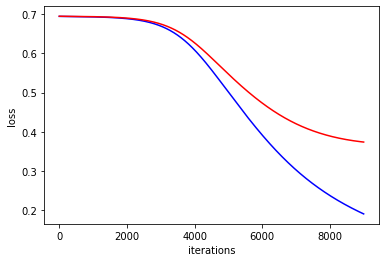

In [147]:
fig = plt.figure()
graph1 = plt.plot(iters, train_costs, 'b')
graph2 = plt.plot(iters, test_costs, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **2. Plot the accuracy curve**

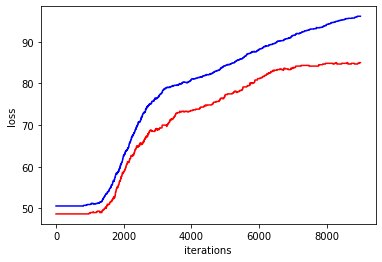

In [148]:
fig = plt.figure()
graph3 = plt.plot(iters, train_accuracys, 'b')
graph4 = plt.plot(iters, test_accuracys, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **3. Plot the accuracy value**

In [149]:
final_train_accuracy = train_accuracys[-1]
final_test_accuracy = test_accuracys[-1]
print("final_train_accuracys :", final_train_accuracy,"%")
print("final_test_accuracys :", final_test_accuracy,"%")

final_train_accuracys : 96.14285714285714 %
final_test_accuracys : 85.0 %


  
    
      
<br>
  
    
   
   

### **4. Plot the classification example**

In [150]:
print("Training results")
print(confusion_matrix(Y_train, predict_train[0]))
print(classification_report(Y_train, predict_train[0]))
print(accuracy_score(Y_train, predict_train[0]))
print("=======================================================")

print("Testing results")
print(confusion_matrix(Y_test, predict_test[0]))
print(classification_report(Y_test, predict_test[0]))
print(accuracy_score(Y_test, predict_test[0]))

Training results
[[660  32]
 [ 22 686]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       692
           1       0.96      0.97      0.96       708

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400

0.9614285714285714
Testing results
[[255  53]
 [ 37 255]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       308
           1       0.83      0.87      0.85       292

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

0.85
